# Install libraries

## Sewar: for image quality assessment.

In [ ]:
!pip install sewar

  Preparing metadata (setup.py) ... done
  Created wheel for sewar: filename=sewar-0.4.6-py3-none-any.whl size=11418 sha256=e64f16de61b24ddc6a63197a8944d581261d1375aa7d0ec3de852535e7a5a7ae
  Stored in directory: /root/.cache/pip/wheels/fb/4e/29/b15a3d425c5f0fe8f461cbfdaf4fa98ef203fed97ce1df6695
Successfully built sewar


This code block imports all the necessary libraries for image processing, analysis, and visualization.

In [ ]:
import sys
# set_printoptions(threshold=sys.maxsize)
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp
from matplotlib import pyplot as plt
import os
import numpy as np
import random
import pandas as pd
from skimage import io

# Download Images
This code block downloads three images (`lake.jpg`, `peppers.jpg`, and `mandril.jpg`) from the provided URLs using the `wget` command. These images will be used as input for the image processing tasks.

In [ ]:
!wget https://i.ibb.co/GxhRPnC/lake-512.jpg -O lake.jpg
!wget https://i.ibb.co/D18bYP1/peppers-color.jpg -O peppers.jpg
!wget https://i.ibb.co/2dckpJ9/mandril-color.jpg -O mandril.jpg
!wget https://i.ibb.co/2StQxJm/bw.jpg -O bw.jpg

--2025-10-10 11:47:22--  https://i.ibb.co/GxhRPnC/lake-512.jpg
Resolving i.ibb.co (i.ibb.co)... 108.181.22.211
Connecting to i.ibb.co (i.ibb.co)|108.181.22.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169146 (165K) [image/jpeg]
Saving to: ‘lake.jpg’

lake.jpg            100%[===================>] 165.18K   252KB/s    in 0.7s    

2025-10-10 11:47:28 (252 KB/s) - ‘lake.jpg’ saved [169146/169146]

--2025-10-10 11:47:28--  https://i.ibb.co/D18bYP1/peppers-color.jpg
Resolving i.ibb.co (i.ibb.co)... 108.181.22.211
Connecting to i.ibb.co (i.ibb.co)|108.181.22.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144729 (141K) [image/jpeg]
Saving to: ‘peppers.jpg’

peppers.jpg         100%[===================>] 141.34K   564KB/s    in 0.3s    

2025-10-10 11:47:30 (564 KB/s) - ‘peppers.jpg’ saved [144729/144729]

--2025-10-10 11:47:30--  https://i.ibb.co/2dckpJ9/mandril-color.jpg
Resolving i.ibb.co (i.ibb.co)... 108.181.22.211
Connectin

In [ ]:
This code block lists all files in the current directory and prints their names.

In [ ]:
files = [f for f in os.listdir(".") if os.path.isfile(f)]
print(files)

['lake.jpg', 'bw.jpg', 'mandril.jpg', 'peppers.jpg']


# New Functions for measurement


## Convert_b : returns 0 or 1

This code block defines `convert_b`, which also perform a quantum-inspired conversion using a Hadamard matrix. The final value `c` is determined based on a random choice weighted by the squared components of the state vector.

When results of these measurements are averaged out over multiple measurements we get back the almost near original pixel value

In [ ]:
def convert_b(H,i_state):
    cov = np.dot(H,i_state)
    si = cov * (1/np.sqrt (2))
    alpha=si[0][0]
    beta=si[1][0]
    #c = si[0][0] + si[1][0] # a=1/sqrt(2)(b+c)
    #c = (alpha*alpha)+(beta*beta)
    #m=min(alpha, beta) # measurement after largest probability value
    #c=m*m
    t=[alpha , beta]
    e=random.choices(t,weights=[alpha**2,beta**2],k=1)
    if e[0] == alpha:
      c = 0
    else:
      c = 1
    #c=e*e
    return c

# Other conv logics

## conv_img__01_ab converts each pixel into ints binary then applies measurement on each of the bits of the binary value

This code block defines several functions for image conversion, focusing on binary or near-binary image transformations:
- `conv_img_01_ab`: Converts a grayscale image by processing each pixel's binary representation. For each bit, it applies a Hadamard transform-inspired conversion using `convert_b` and reconstructs a new pixel value from the results.


In [ ]:
def conv_img_01_ab(img):
    #small = cv2.resize(img,(256,256))
    small = img
    #small = cv2.cvtColor(small, cv2.COLOR_BGRA2BGR)
    #small = cv2.cvtColor(small, cv2.COLOR_BGR2RGB)
    #small = cv2.cvtColor(small, cv2.COLOR_RGB2GRAY)
    #cv2_imshow(small)
    H = np.array([[1,1],[1,-1]])
    converted = np.zeros((256,256))
    list_st=[]
    for i in range(0,len(img)) :
      for j in range(0,len(img[0])):
        a = img[i][j]
        lst = []
        measure = []
        lst = list(np.binary_repr(img[i][j] ,width=8))
        #a2 = b/255
        for element in lst:
          if element == "0":
              i_state= np.array([[1],[0]])
          else:
              i_state= np.array([[0],[1]])
          # print(si)
          c = convert_b(H,i_state)
          measure += [str(c)]
        #c = c / sqrt(2)
        #print(lst,measure)
        converted [i][j] = int(''.join(measure), 2)
    #list_st = np.array(list_st)
    #print(np.mean(list_st),"+-",np.var(list_st))

    return converted

This code block function for image conversion with RGB channel, focusing on binary or near-binary image transformations:
- `conv7_rgb`: Converts a color image by applying `conv_img_01_ab` to each color channel and combining the results.


In [ ]:
def conv7_rgb(img):
    #img = cv2.imread(fname)
    img = cv2.resize(img,(256,256))
    b, g, r    = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    b1, g1, r1 = conv_img_01_ab(b), conv_img_01_ab(g), conv_img_01_ab(r)
    img[:,:,0], img[:,:,1], img[:,:,2] = b1, g1, r1
    return img

# Define function to perform multiple measurements and average out

This code block defines several functions `convshots7` that apply image conversion functions `conv7_rgb` multiple times (controlled by the `shots` parameter) and then average the results to produce a final converted image. This simulates a process involving multiple measurements or trials

## Convshots7 is for binary based measurement

In [ ]:
def convshots7(img,shots=1):
    img_list=[]
    for i in range(shots):
        conv2 = conv7_rgb(img)
        img_list += [conv2]
    converted = np.zeros((256,256,3))
    sh = 0
    print(len(img),len(img[0]))
    for i in range(0,len(img)):
         for j in range(0,len(img[0])):
           for k in range(0,len(img[0][0])):
                #val = {}
                val = 0
                for l in range(shots):
                    #print(i,j,k,l,img_list[l][i][j][k])
                    val += img_list[l][i][j][k]
                    '''
                    if img_list[l][i][j][k] in val:
                        val[img_list[l][i][j][k]]+=1
                    else:
                        val[img_list[l][i][j][k]]=1
                keys = list(val.keys())
                print(val)
                if(len(keys)>1):
                    if val[keys[0]]>val[keys[1]]:
                        converted[i][j][k] = keys[0]
                    else:
                        converted[i][j][k] = keys[1]
                else:
                    converted[i][j][k] = keys[0]
                    '''
                converted[i][j][k] = val/shots
                #print(sh)
                sh+=1
    return converted

# Run convshots7 on all three images and get image analysis result
This code block iterates through the files in the current directory, loads each image, resizes it, and applies the `convshots7` function with a varying number of shots (1 and 10). It then displays the converted image, saves it to a file, and calculates various image quality metrics (MSE, RMSE, PSNR, SSIM, UQI, MSSSIM, ERGAS, SCC, RASE, SAM) by comparing the restored image with the original. These metrics and the filename are stored in a pandas DataFrame. The code block was interrupted during execution.

lake.jpg
256 256


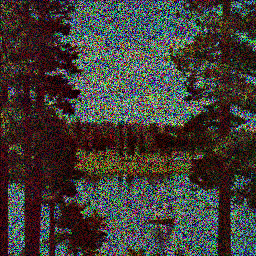

KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame()
for filey in files:
    print(filey)
    img = cv2.imread(filey)
    small = cv2.resize(img,(256,256))
    for k in (1,100,1000):
        #small = cv2.cvtColor(small, cv2.COLOR_BGRA2GRAY)
        #small = cv2.cvtColor(small, cv2.COLOR_BGR2RGB)
        #plt.imsave(filey.split(".")[0]+"_real.jpg",small)
        # cv2.imwrite(filey.split(".")[0]+"_real.jpg",small)
        #real = cv2.imread(filey.split(".")[0]+"_real.jpg")
        real = small
        conv = convshots7(real,k)
        #conv = cv2.cvtColor(conv, cv2.COLOR_BGR2RGB)
        cv2_imshow(conv)
        #plt.imsave(filey.split(".")[0]+"_conv.jpg", conv)
        cv2.imwrite(filey.split(".")[0]+str(k)+"_conv_a.jpg",conv)
        restored = cv2.imread(filey.split(".")[0]+str(k)+"_conv_a.jpg")
        values = {
            "Name": filey,
            "MSE": np.round(mse(restored,real),3),
            "RMSE": np.round(rmse(restored, real),3),
            "PSNR": np.round(psnr(restored, real),3),
            "SSIM": (np.round(ssim(restored, real)[0],3),np.round(ssim(restored, real)[1],3)),
            "UQI": np.round(uqi(restored, real),3),
            "MSSSIM": np.round(msssim(restored, real).real,3),
            "ERGAS": np.round(ergas(restored, real),3),
            "SCC": np.round(scc(restored, real),3),
            "RASE": np.round(rase(restored, real),3),
            "SAM": np.round(sam(restored, real),3)
        }
        df = pd.concat([df,pd.DataFrame.from_dict([values])])